In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import os
import glob2 as glob
import torch
from torch.utils.data import DataLoader
from src.utilities.data_utilities import PointDataReg
from torch.utils.data.sampler import SubsetRandomSampler
from src.point_net_nl.point_net import PointNetRegHead
from src.point_net_nl.point_net_loss import PointNetRegLoss

In [10]:
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
fluo_channel = "tbx5a-StayGold_mean"
training_dates = ["20240424", "20240425"]
point_cloud_size = 4096

model_dir = os.path.join(root, "built_data", "nucleus_data", "point_models", "*")
model_list = sorted(glob.glob(model_dir))
model_path = os.path.join(model_list[-1], "seg_model.pth") # take most recent

In [11]:
# use dataloader to import sample point clouds
data_root = os.path.join(root, "built_data", "nucleus_data", "point_clouds")

# generate dataloader to load fin point clouds
point_data = PointDataReg(data_root, split='train', training_dates=training_dates,
                                                                npoints=point_cloud_size, fluo_channel=fluo_channel)

train_loader = DataLoader(point_data, batch_size=16, shuffle=True)

In [12]:
# check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load pretrained model
model = PointNetRegHead(num_points=point_cloud_size).to(device)
model.load_state_dict(torch.load(model_path)) # load weights from previous training as starting point
model.eval()

batch = next(iter(train_loader))

points = batch["data"]
levels = batch["label"]
points = torch.transpose(points, 1, 2)

# pass to device
points = points.to(device)
levels = levels.to(device)

# get softmax predictions
preds, _, _ = model(points)

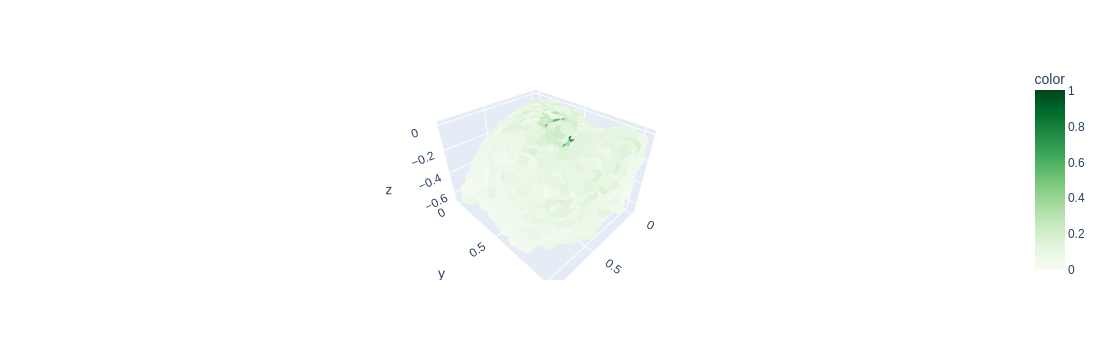

In [20]:
# plot ground truth
sample_ind = 2
points_samp = np.squeeze(points[sample_ind, :, :]).T.cpu().numpy()
tbx5a_samp = np.squeeze(levels[sample_ind, :, :]).cpu().numpy()

# plot true gene expression
fig = px.scatter_3d(x=points_samp[:, 0], y=points_samp[:, 1], z=-points_samp[:, 2], color=tbx5a_samp, 
                    color_continuous_scale="Greens", opacity=1)
fig.show()

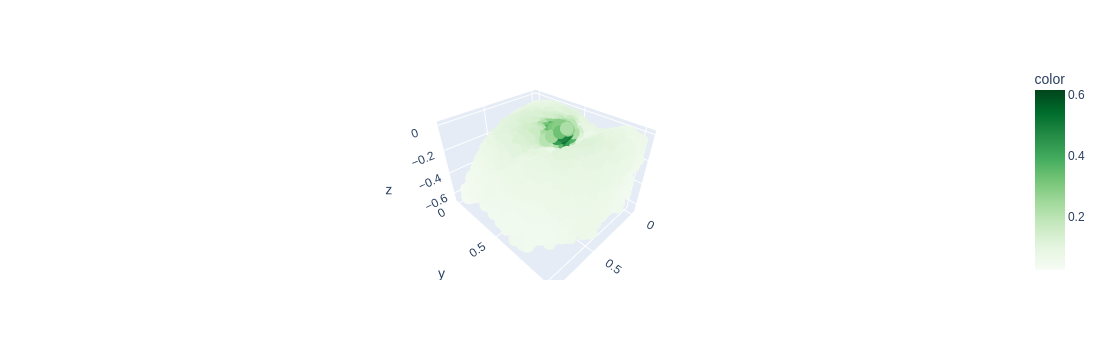

In [21]:
tbx5a_pd = np.squeeze(preds[sample_ind, :, :]).detach().cpu().numpy()

# plot true gene expression
fig = px.scatter_3d(x=points_samp[:, 0], y=points_samp[:, 1], z=-points_samp[:, 2], color=tbx5a_pd, 
                    color_continuous_scale="Greens", opacity=1)
fig.show()

In [32]:
from sklearn.decomposition import PCA

n_components = 10
n_local = 64
pca = PCA(n_components=n_components)

point_features, crit_idxs, A_feat = model.backbone(points) 
features_samp = np.squeeze(point_features[sample_ind, :, :].detach().cpu().numpy()).T

pca.fit(features_samp[:, :n_local])
pca_array = pca.transform(features_samp[:, :n_local])
pca_array.shape

(4096, 10)

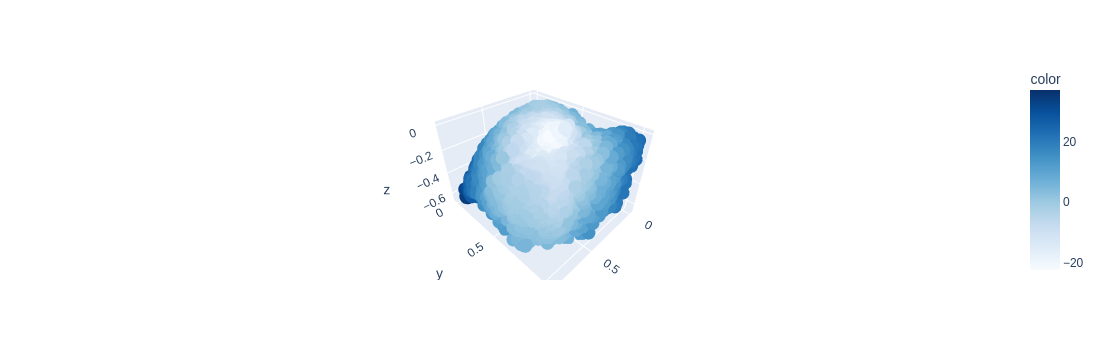

In [35]:
# plot true gene expression
fig = px.scatter_3d(x=points_samp[:, 0], y=points_samp[:, 1], z=-points_samp[:, 2], color=pca_array[:, 2], 
                    color_continuous_scale="Blues", opacity=1)
fig.show()

In [37]:
test_dates = ["20240223"]
# generate dataloader to load fin point clouds
test_data = PointDataReg(data_root, split='test', training_dates=test_dates,
                                                                npoints=point_cloud_size, fluo_channel=None)

test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

test_batch = next(iter(test_loader))

test_points = test_batch["data"]
# test_levels = batch["label"]
test_points = torch.transpose(test_points, 1, 2)

# pass to device
test_points = test_points.to(device)
# levels = levels.to(device)

# get softmax predictions
test_preds, _, _ = model(test_points)

In [49]:
# plot prediction
sample_ind = -5
points_samp = np.squeeze(test_points[sample_ind, :, :]).T.cpu().numpy()
tbx5a_pd = np.squeeze(test_preds[sample_ind, :, :]).detach().cpu().numpy()

# plot true gene expression
fig = px.scatter_3d(x=-points_samp[:, 0], y=points_samp[:, 1], z=-points_samp[:, 2], color=tbx5a_pd,
                    color_continuous_scale="Greens_r", opacity=1)

fig.update_traces(marker=dict(size=5))

fig.show()

In [50]:
n_components = 10
n_local = 64
pca = PCA(n_components=n_components)

point_features, crit_idxs, A_feat = model.backbone(test_points) 
features_samp = np.squeeze(point_features[sample_ind, :, :].detach().cpu().numpy()).T

pca.fit(features_samp[:, :n_local])
pca_array = pca.transform(features_samp[:, :n_local])
pca_array.shape

(4096, 10)

In [55]:
fig = px.scatter_3d(x=points_samp[:, 0], y=points_samp[:, 1], z=-points_samp[:, 2], color=pca_array[:, 5], 
                    color_continuous_scale="Blues", opacity=1)
fig.show()